### Load libs

In [27]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras

from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Flatten, Activation
from keras.models import Sequential, Model

import os
import cv2


%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

### Helpers. Params. Preprocesing


In [28]:
def fixed_generator(generator):
    for batch in generator:
        yield (batch, batch)   

In [29]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [89]:
#Test any image
def ImageHasdefect(model, filePath,threshold):  
    im = cv2.resize(cv2.imread(filePath), (3660, 252))
    im = im * 1./255

    #validation_image = np.zeros((1,  3660, 252, 3))
    validation_image[0, :, :, :] = im;   
    predicted_image = model.predict(validation_image)
    _mse = mse(predicted_image[0], validation_image[0]) 
    print('_mse: {}'.format(_mse))
    return _mse  > threshold

In [31]:
img_width, img_height = 252, 3660


batch_size = 32

nb_validation_samples=0
nb_train_samples=0

nb_epoch=20

initial_image_dir='.NN_method/images/docs'
train_data_dir = initial_image_dir + '/train'
validation_data_dir = initial_image_dir + '/valid'

#### Generator for images to complete dataset
Generator is used for extending the image dataset by image transformation

In [32]:
datagen = ImageDataGenerator(
    rotation_range=2,
         
        rescale=1./255,
        
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

#### New image generation flow

In [33]:
image_list = os.listdir(initial_image_dir) #initial path to images

inital_image_count=0
for img in image_list:   
    img_path= initial_image_dir + '/' + img
    if not os.path.isfile(img_path):
        continue
       
    inital_image_count += 1  
    
    img = load_img(img_path)  # this is a PIL image
    x = img_to_array(img)  
    x = x.reshape((1,) + x.shape)  
    
    train_save_to = train_data_dir + '/correct_samples'
    if not os.path.exists(train_save_to):
        os.makedirs(train_save_to)
    
    valid_save_to = validation_data_dir + '/correct_samples'
    if not os.path.exists(valid_save_to):
        os.makedirs(valid_save_to)
    
    print("generate additional images for train in: " + train_save_to)
    
    i = 0
    for batch in datagen.flow(x, batch_size=5, save_to_dir = train_save_to, save_prefix='sampleIM', save_format='jpg'):
        i += 1
        if i > 100:
            break  # otherwise the generator would loop indefinitely

    train_size=0            
    for t in os.listdir(train_save_to):
        if os.path.isfile(train_save_to +"/" + t):
            train_size += 1 
            
            
    print("generate additional images for validation in: " + valid_save_to)
    j=0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=valid_save_to, save_prefix='valIm', save_format='jpg'):
        j += 1
        if j > 20:
            break  # otherwise the generator would loop indefinitely
            
    validation_size=0            
    for v in os.listdir(valid_save_to):
        if os.path.isfile(valid_save_to+"/" +v):
            validation_size += 1 
            
print("-------------------------------------------")
print("Initial image count: {} ".format(inital_image_count))
print("Train image count: {} ".format(train_size))
print("Validation image count: {} ".format(validation_size))

generate additional images for train in: /efs/workspace/cnn-anomaly-detection-keras/images/docs/train/correct_samples
generate additional images for validation in: /efs/workspace/cnn-anomaly-detection-keras/images/docs/valid/correct_samples
generate additional images for train in: /efs/workspace/cnn-anomaly-detection-keras/images/docs/train/correct_samples
generate additional images for validation in: /efs/workspace/cnn-anomaly-detection-keras/images/docs/valid/correct_samples
generate additional images for train in: /efs/workspace/cnn-anomaly-detection-keras/images/docs/train/correct_samples
generate additional images for validation in: /efs/workspace/cnn-anomaly-detection-keras/images/docs/valid/correct_samples
-------------------------------------------
Initial image count: 3 
Train image count: 299 
Validation image count: 63 


### Exract data for train and test

In [34]:
# this is the augmentation configuration we will use for training
# only rescaling
train_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures
train_generator = train_datagen.flow_from_directory(
        train_data_dir,  # this is the target directory
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        color_mode='rgb', 
        class_mode=None)  

nb_train_samples=train_generator.samples
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        color_mode='rgb', 
        class_mode=None)

nb_validation_samples=validation_generator.samples

Found 299 images belonging to 1 classes.
Found 63 images belonging to 1 classes.


### Build Simplest Model

In [35]:
input_img = Input(batch_shape=(None, img_width, img_height, 3))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

model = Model(input_img, decoded)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy')

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 252, 3660, 3)]    0         
                                                                 
 conv2d_7 (Conv2D)           (None, 252, 3660, 16)     448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 126, 1830, 16)    0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 126, 1830, 8)      1160      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 915, 8)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 63, 915, 8)        584 

### Train our network

In [36]:
model.fit(
        fixed_generator(train_generator),
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=nb_epoch,
        validation_data=fixed_generator(validation_generator),
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
9/9 [==============================] - 44s 5s/step - loss: 0.6819 - val_loss: 0.6554
Epoch 2/20
9/9 [==============================] - 42s 5s/step - loss: 0.6234 - val_loss: 0.6074
Epoch 3/20
9/9 [==============================] - 40s 5s/step - loss: 0.5885 - val_loss: 0.5662
Epoch 4/20
9/9 [==============================] - 40s 5s/step - loss: 0.5448 - val_loss: 0.5207
Epoch 5/20
9/9 [==============================] - 40s 5s/step - loss: 0.4901 - val_loss: 0.4670
Epoch 6/20
9/9 [==============================] - 40s 5s/step - loss: 0.4668 - val_loss: 0.4655
Epoch 7/20
9/9 [==============================] - 42s 5s/step - loss: 0.4607 - val_loss: 0.4550
Epoch 8/20
9/9 [==============================] - 40s 5s/step - loss: 0.4607 - val_loss: 0.4667
Epoch 9/20
9/9 [==============================] - 40s 5s/step - loss: 0.4591 - val_loss: 0.4579
Epoch 10/20
9/9 [==============================] - 40s 5s/step - loss: 0.4588 - val_loss: 0.4609
Epoch 11/20
9/9 [======================

### Save weights

In [37]:
model.save_weights('defect-detection.h5')

### Load weights

In [38]:
model.load_weights('defect-detection.h5');

### Test encoder and visualize result

1/1 [==============================] - 0s 256ms/step


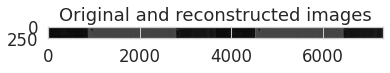

In [39]:
img = next(validation_generator)[:7] # Get random image

dec = model.predict(img) # Decoded image
img = img[0]
dec = dec[0]
img = (img*255).astype('uint8')
dec = (dec*255).astype('uint8')

plt.imshow(np.hstack((img, dec)))
plt.title('Original and reconstructed images')
plt.show()

 Selecting th

In [84]:
# base on visulization lets say that everething that more then threshold likelihood defect
# set threshold manually
threshold=0.00065

In [93]:
#checking against correct images as the model is trained with defective images
ImageHasdefect(model, './NN_method/correct.jpg',threshold)

1/1 [==============================] - 1s 807ms/step
_mse: 0.0006001763445255377


False